In [2]:
# CLone the github repository
!git clone https://github.com/VarunBiyyala/LPPLS-Net.git

Cloning into 'LPPLS-Net'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 37 (delta 7), reused 15 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 1.15 MiB | 6.46 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [3]:
# Change to repo directory and install all required packages
%cd LPPLS-Net/
!pip install -r requirements.txt

/content/LPPLS-Net


Generating synthetic dataset...
Dataset generation complete! Size: 100000
Train dataset size: 80000, Val dataset size: 20000
Plot saved to dataset_samples.png


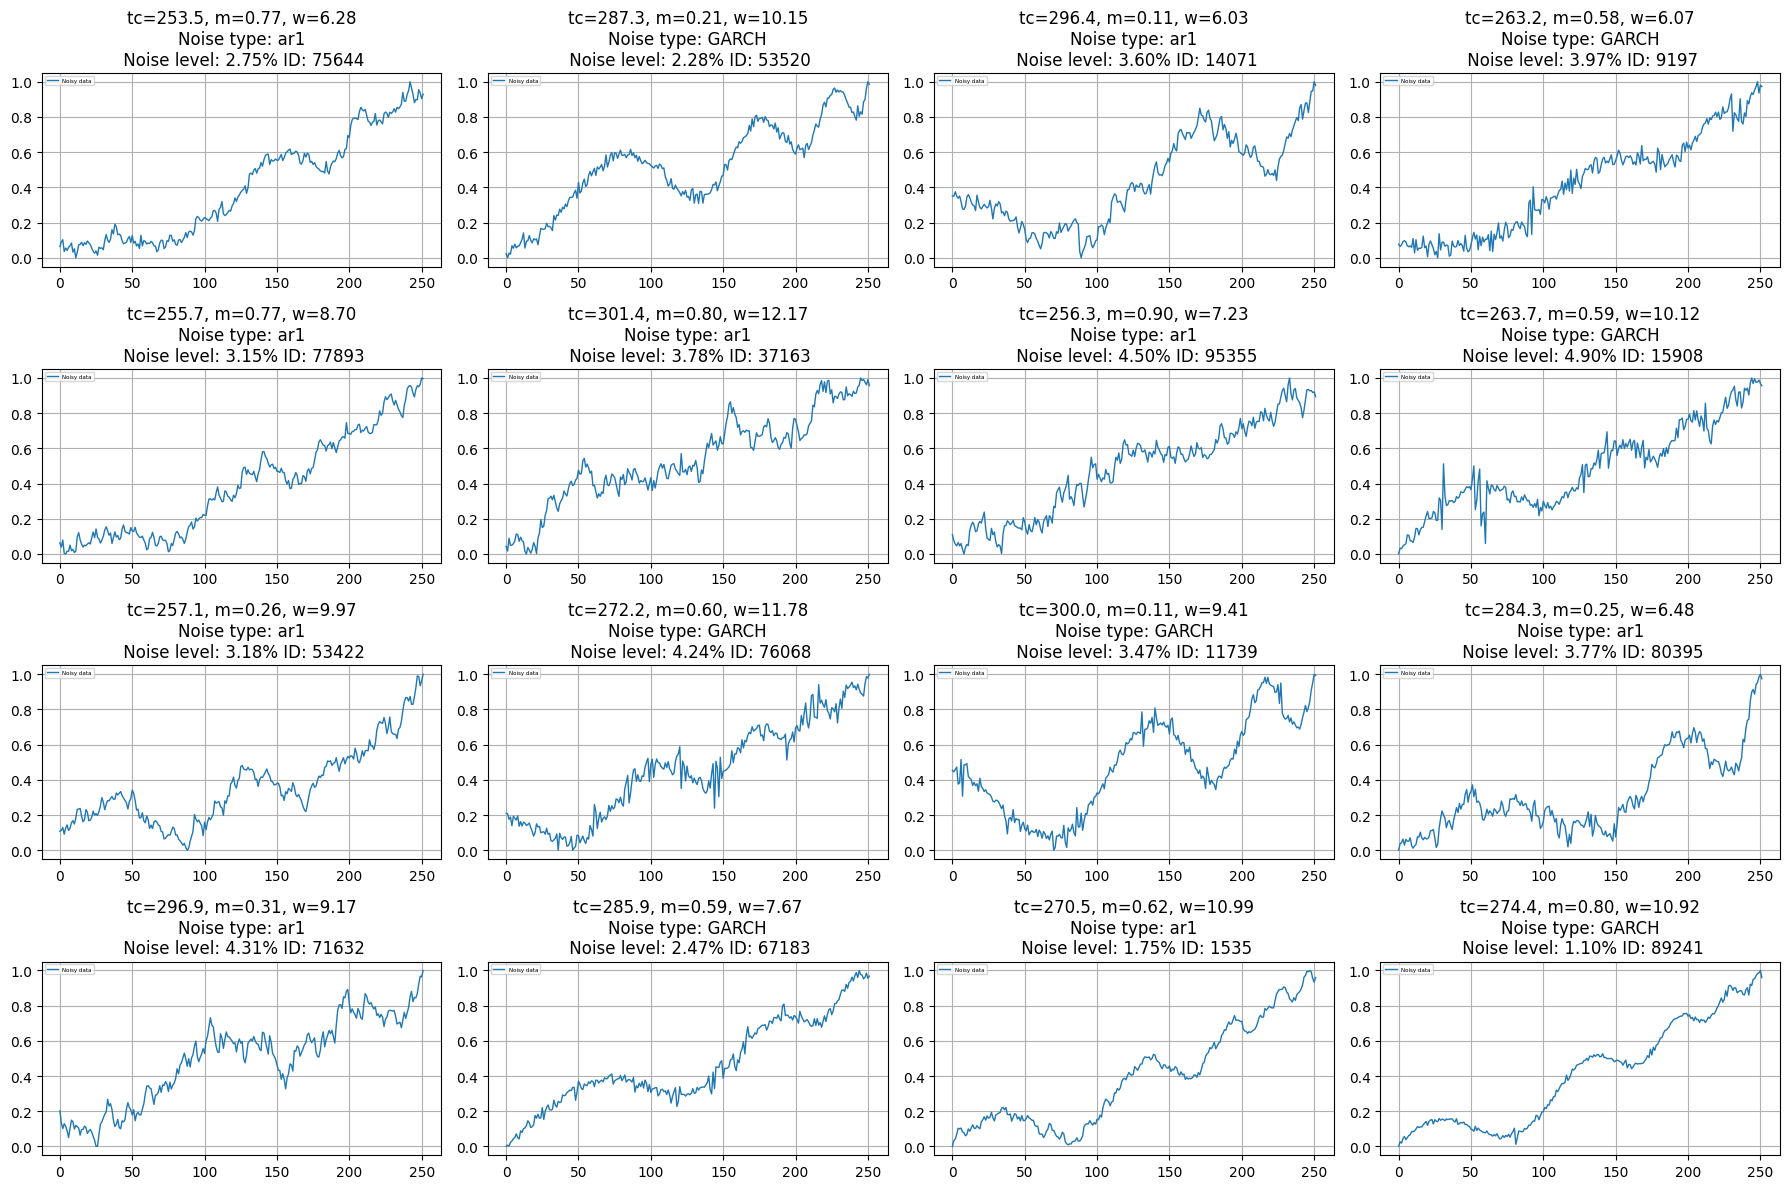

In [4]:
# ---
# Generate Synthetic Datasets for Experimentation
#
# This block creates two datasets (training and validation) using a model that simulates financial time series with realistic noise (AR(1) + GARCH).
# - n_samples: Number of synthetic time series to generate (default: 10,000)
# - n_points:  Number of data points per series (default: 252, roughly 1 year of daily data)
# - noise_type: Use any of these noise type strings - 'white', 'ar1', 'ARCH', 'GARCH', 'white+ar1', 'ARCH+GARCH' or 'ar1+GARCH'
# - phi: Strength of AR(1) autocorrelation (0.8 = strong memory)
#
# After generating the data, it displays a sample image so you can see example synthetic time series.
#
# 💡 Try changing the numbers to see how the output changes!
# ---

from src.data_utils import call_generate_synthetic_dataset
from PIL import Image

train_dataset, val_dataset = call_generate_synthetic_dataset(n_samples=100000, n_points=252, noise_type="ar1+GARCH", phi=0.8)
im = Image.open('dataset_samples.png')
im.show()

Model created. Training...
Using device: cuda
Epoch 5/100, Train Loss = 0.049678, Val Loss = 0.048413
Epoch 10/100, Train Loss = 0.041631, Val Loss = 0.040989
Epoch 15/100, Train Loss = 0.037875, Val Loss = 0.037487
Epoch 20/100, Train Loss = 0.035672, Val Loss = 0.035828
Epoch 25/100, Train Loss = 0.034139, Val Loss = 0.034045
Early stopping at epoch 27 due to no 1% improvement in train/val loss for 1 epochs.
Training complete!


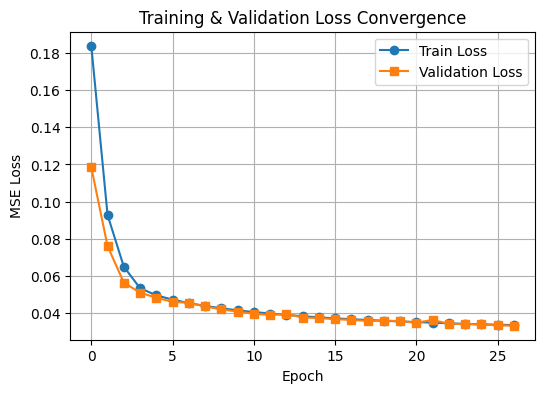

In [5]:
# ---
# Train the LPPLS-Net Model and Visualize Learning Progress
#
# This block builds the LPPLS-Net model and trains it on your synthetic datasets.
# It then plots how the model’s accuracy improves over time (loss curves).
#
# 💡 You can adjust training parameters (like n_epochs, batch_size or learning_rate (lr)) to see how training changes.
# ---

from src.model_utils import PLNNet1, train_p_lnn
import matplotlib.pyplot as plt

# Build the P-LNN model
model = PLNNet1(n_points=252, hidden_size=256)
print("Model created. Training...")

# Train
train_losses, val_losses = train_p_lnn(model, train_dataset, val_dataset, n_epochs=100, batch_size=8, lr=1e-5, patience=1)
print("Training complete!")

# Plot the training & validation loss curves
plt.figure(figsize=(6,4))
plt.plot(train_losses, marker='o', label="Train Loss")
plt.plot(val_losses, marker='s', label="Validation Loss")
plt.title("Training & Validation Loss Convergence")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()

In [6]:
# ---
# Generate a Small Test Dataset for Experimentation
#
# This block creates a small synthetic test dataset (50 time series) with realistic noise.
# You can use this data to quickly test the model or try out new ideas.
#
# 💡 Tip: Change 'n_samples' or 'noise_type' to see how the test data changes!
# ---

from src.data_utils import generate_synthetic_dataset

print("Generating test dataset...")
test_dataset = generate_synthetic_dataset(n_samples=500,
                                      n_points=252,
                                      noise_type='ar1+GARCH',
                                      )
print("Test Dataset generation complete! Size:", len(test_dataset))

Generating test dataset...
Test Dataset generation complete! Size: 500


Using device: cuda


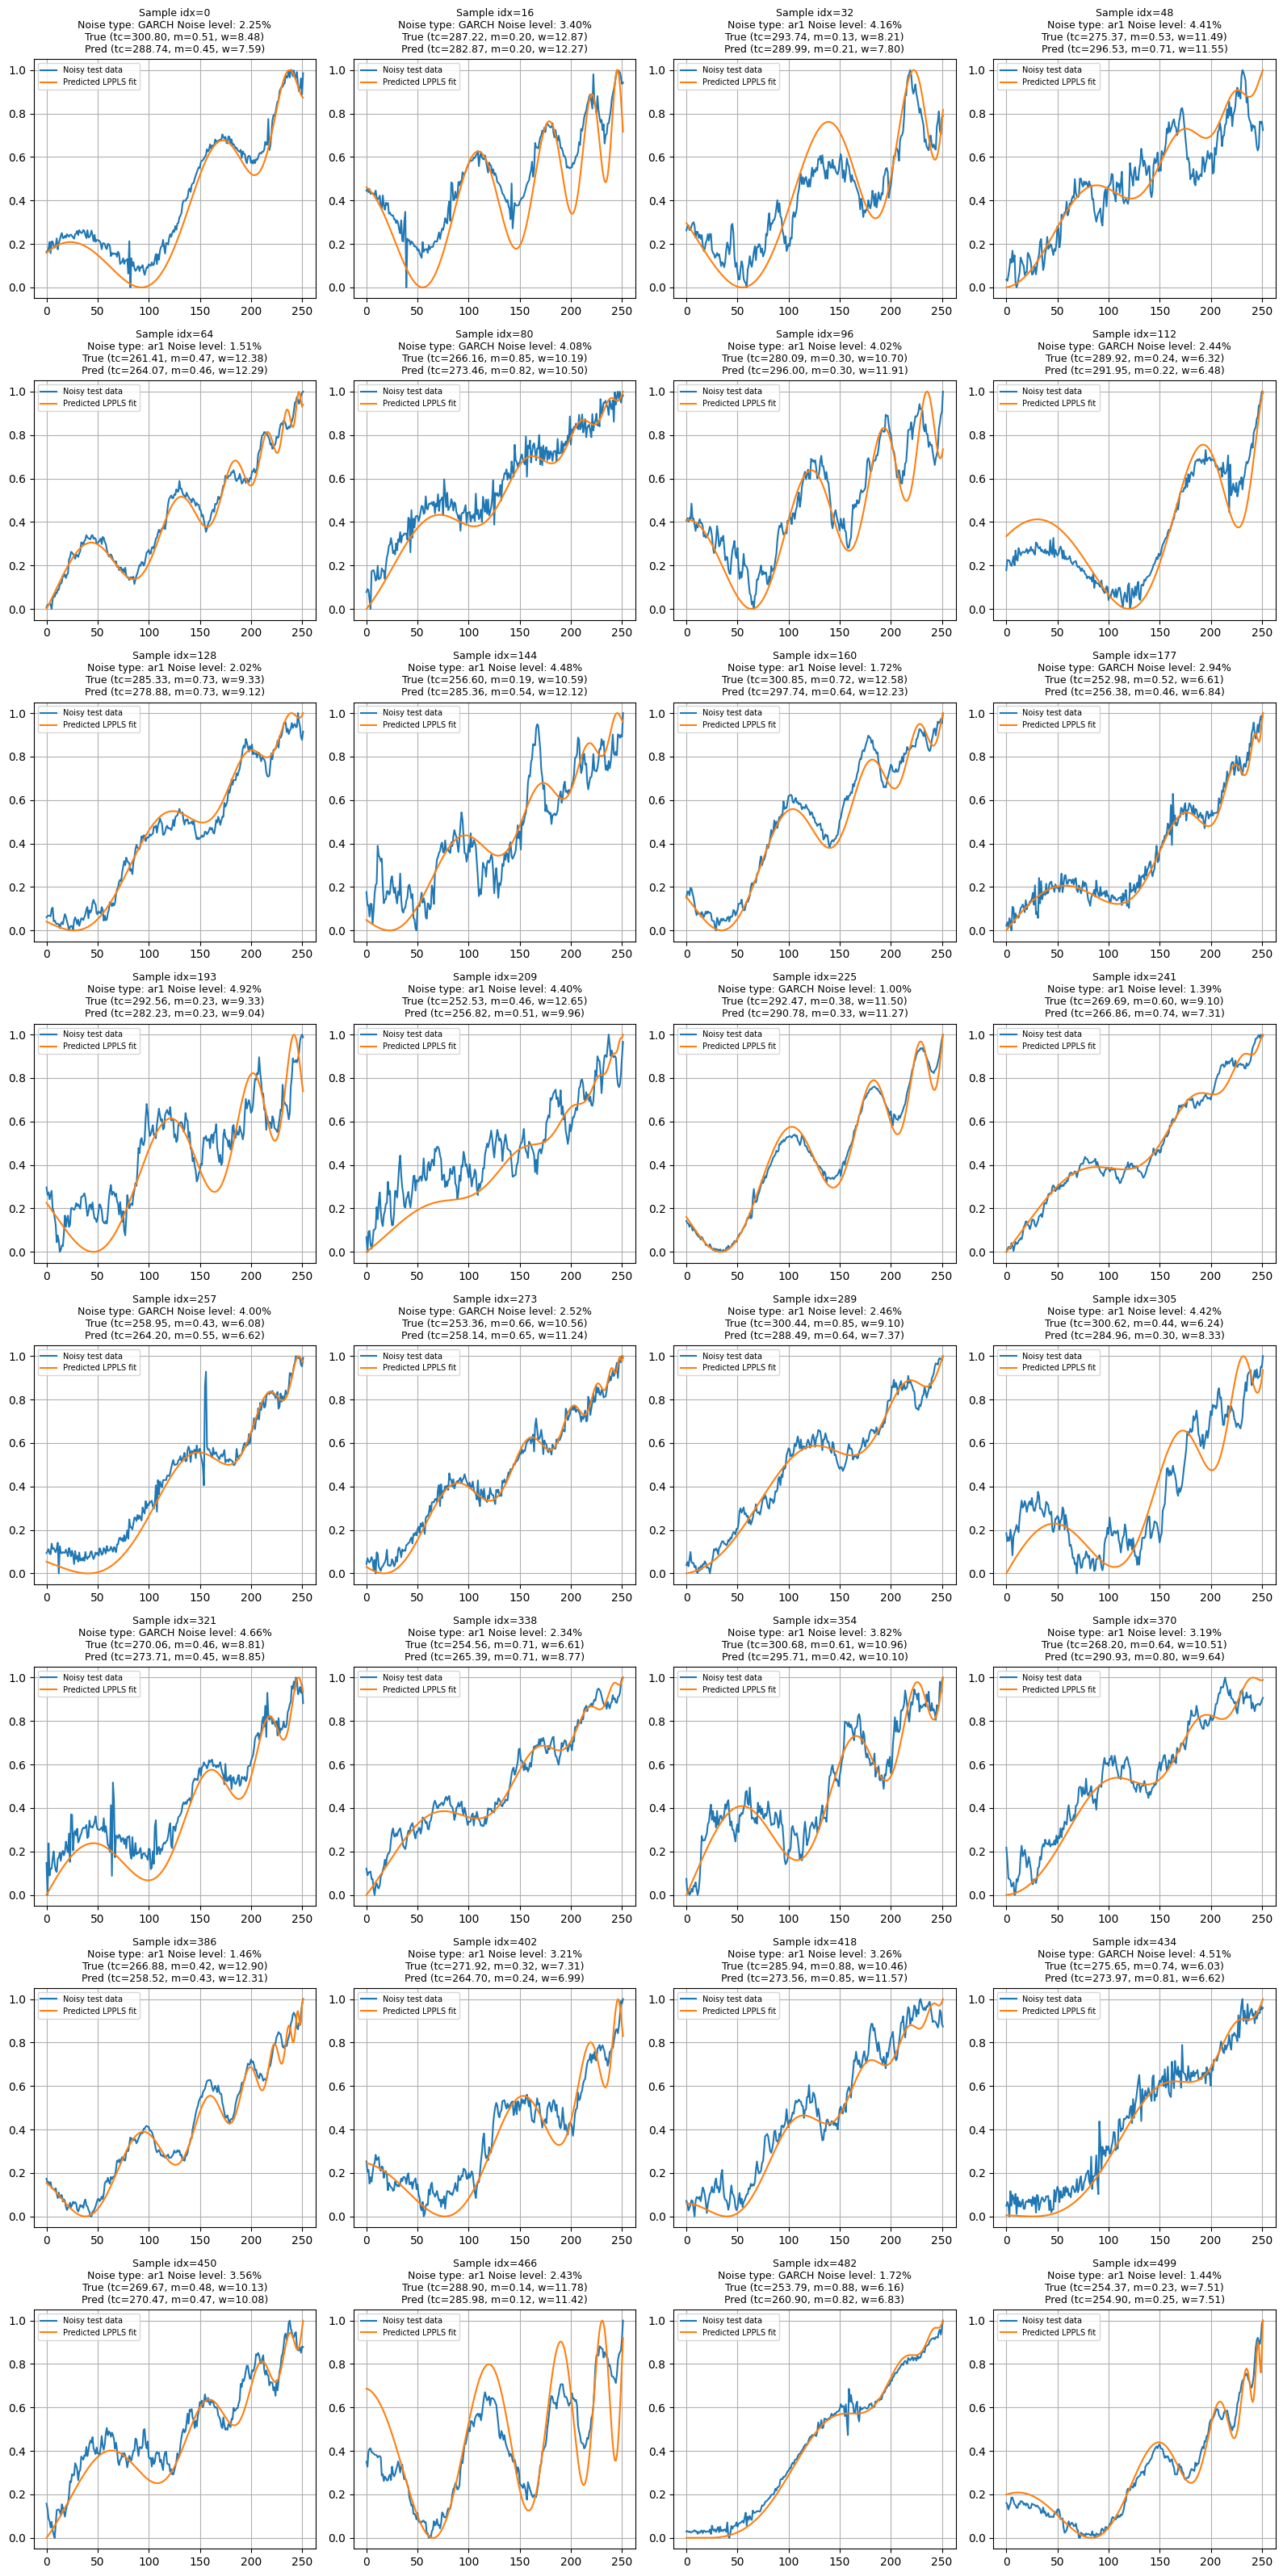


Parameter-space MSE on these 32 test samples: 35.954544


In [7]:
# ---
# Evaluate the Trained Model and Visualize Its Predictions
#
# This block uses the trained LPPLS-Net model to make predictions on the test dataset.
# It also creates a grid of plots to show how well the model can fit and forecast different synthetic time series.
#
# - n_samples: Number of series to plot (try 16 for a 4x4 grid, or 32 for 8x4)
# - n_rows/n_cols: Control the grid layout for visualizing results
#
# 💡 Try changing the grid size or n_samples to explore different visualizations!
# ---

from src.eval import evaluate_and_plot_lppls
from src.lppls_utils import predict_linear_params, reconstruct_lppls

test_loss = evaluate_and_plot_lppls(
    model,
    test_dataset,
    predict_linear_params,
    reconstruct_lppls,
    n_samples=32,   # or 16 if you want a 4x4 grid
    n_rows=8,       # adjust accordingly
    n_cols=4,
    n_points=252
)

In [8]:
# ---
# Evaluate Model Accuracy on complete Test Data
#
# This block measures how well the model predicts key parameters on the entire test dataset (using Mean Squared Error).
# ---

from src.eval import evaluate_model_param_mse

test_loss = evaluate_model_param_mse(model, test_dataset)


Parameter-space MSE on all 500 test samples: 31.144493


/content/LPPLS-Net/src/eval.py:129: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  all_targets_t = torch.tensor(all_targets, dtype=torch.float32)


Using device: cuda


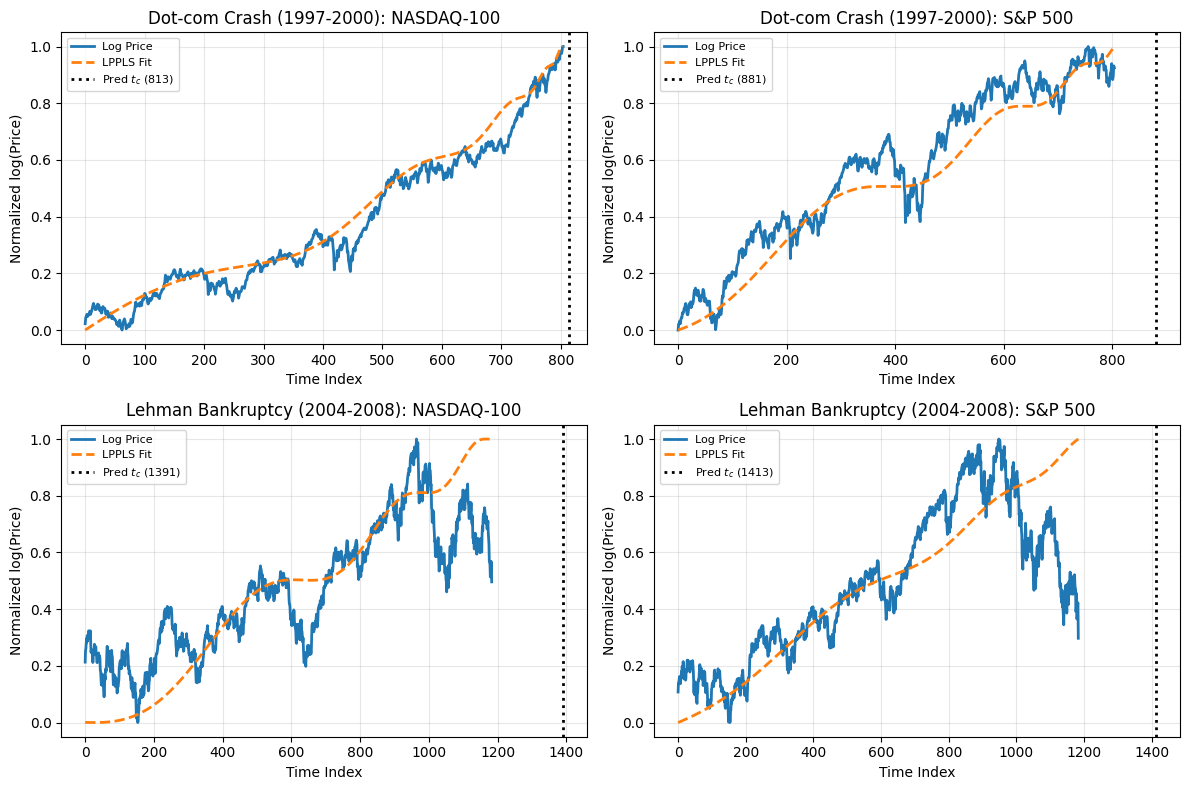

In [9]:
# ---
# Evaluate LPPLS-Net on Real Market Scenarios
#
# This block tests the trained model on actual historical data from major market events
# (e.g., Dot-com Crash and Lehman Bankruptcy) for NASDAQ-100 and S&P 500.
# The function will plot how the model predicts critical points during these real-world crashes.
#
# 💡 You can edit the 'scenarios' or 'tickers' dictionaries to try different date ranges or market indices.
# ---

from src.market_eval import plot_lppls_scenarios
import numpy as np
import datetime

def lppl_test(t, tc, m, w, a, b, c1, c2):
    return a + np.power(tc - t, m) * (b + (c1 * np.cos(w * np.log(tc - t)) + c2 * np.sin(w * np.log(tc - t))))

scenarios = {
    'Dot-com Crash': (datetime.datetime(1997, 1, 1), datetime.datetime(2000, 3, 10)),
    'Lehman Bankruptcy': (datetime.datetime(2004, 1, 1), datetime.datetime(2008, 9, 15)),
}
tickers = {'NASDAQ-100': '^NDX', 'S&P 500': '^SPX'}

axs, result_dict = plot_lppls_scenarios(
    model,
    predict_linear_params,
    lppl_test,
    tickers,
    scenarios,
    figsize=(12, 8),
    N_SELECT=252
)
